# GOAL
Predict tomorrow's temperature, given the temprature until today, as precisely as possible.

In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# machine learning stack
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.arima_process import ArmaProcess
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score





# time-related stack
from dateutil.relativedelta import relativedelta
from datetime import datetime as dt

# miscellaneous
import time
import warnings
warnings.filterwarnings("ignore")

# Data
Data was preprossed in "time_series_data_processing.ipynb"

# Baseline Model CV

In [54]:
# load data
train = pd.read_csv('data/train.csv',index_col=0,parse_dates=True)
train.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [55]:
# add timestep column
train['timestep'] = list(range(train.shape[0]))

In [56]:
# add month column
train['month'] = train.index.month

In [59]:
# features and target for train set
Xb = train[['timestep','month']]
yb = train['temp']

In [61]:
transformer = ColumnTransformer([
    ('poly', PolynomialFeatures(), ['timestep']),
    ('ohe', OneHotEncoder(drop='first', sparse = False), ['month'])]
)

In [62]:
estimator = Pipeline([
        ('transformer', transformer),
        ('lr', LinearRegression())]
)

In [63]:
param_grid = {'transformer__poly__degree': [2,3,4,]}

In [64]:
cv = TimeSeriesSplit(n_splits=3)

In [65]:
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='r2',
    cv=cv, 
    n_jobs=-1
)

In [66]:
# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(Xb,yb)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

time taken: 3.15 sec


In [67]:
column_list = ['param_transformer__poly__degree',
               'mean_test_score',
               'std_test_score',
               'rank_test_score'
              ]
result_df = pd.DataFrame(gscv.cv_results_)[column_list]

result_df.rename(
    columns=lambda name: name.split('__')[-1],inplace=True
)
result_df

,degree,mean_test_score,std_test_score,rank_test_score
0,2,0.742623,0.011953,1
1,3,-1.710072,3.396979,2
2,4,-2.278580,1.423619,3


In [68]:
gscv.best_params_

{'transformer__poly__degree': 2}

In [69]:
#instantiate best estimator
baseline_model_cv = gscv.best_estimator_

In [70]:
# build model
baseline_model_cv.fit(Xb,yb)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('poly', PolynomialFeatures(),
                                                  ['timestep']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['month'])])),
                ('lr', LinearRegression())])

In [71]:
#postdiction train data
train['baseline_pred_cv'] = baseline_model_cv.predict(Xb)

In [72]:
#check results
train[['temp','baseline_pred_cv']].tail()

,temp,baseline_pred_cv
date,,
2021-12-27,-3.9,2.924448
2021-12-28,-0.5,2.924559
2021-12-29,4.5,2.924669
2021-12-30,9.3,2.924780
2021-12-31,13.0,2.924891


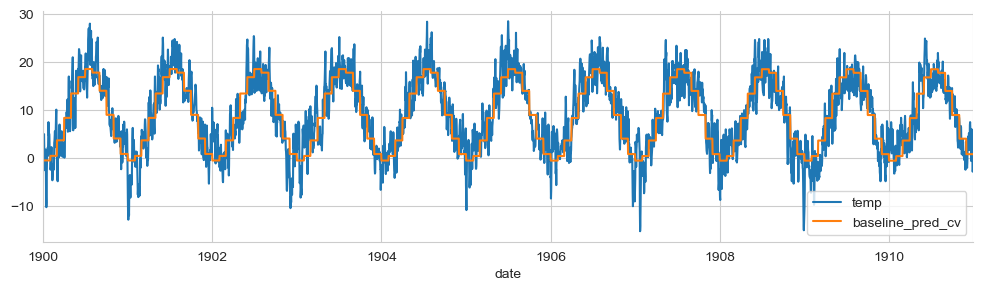

In [73]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['temp','baseline_pred_cv']].loc['1900':'1910'].plot(legend=True)
sns.despine()

In [74]:
# leftover time series devoid of trend and seasonality
train['remainder'] = train['temp'] - train['baseline_pred_cv']
train.head()

,temp,timestep,month,baseline_pred_cv,remainder
date,,,,,
1876-01-01,2.2,0,1,-0.184466,2.384466
1876-01-02,2.5,1,1,-0.184511,2.684511
1876-01-03,0.3,2,1,-0.184556,0.484556
1876-01-04,-5.8,3,1,-0.184601,-5.615399
1876-01-05,-9.8,4,1,-0.184646,-9.615354


<AxesSubplot: xlabel='date'>

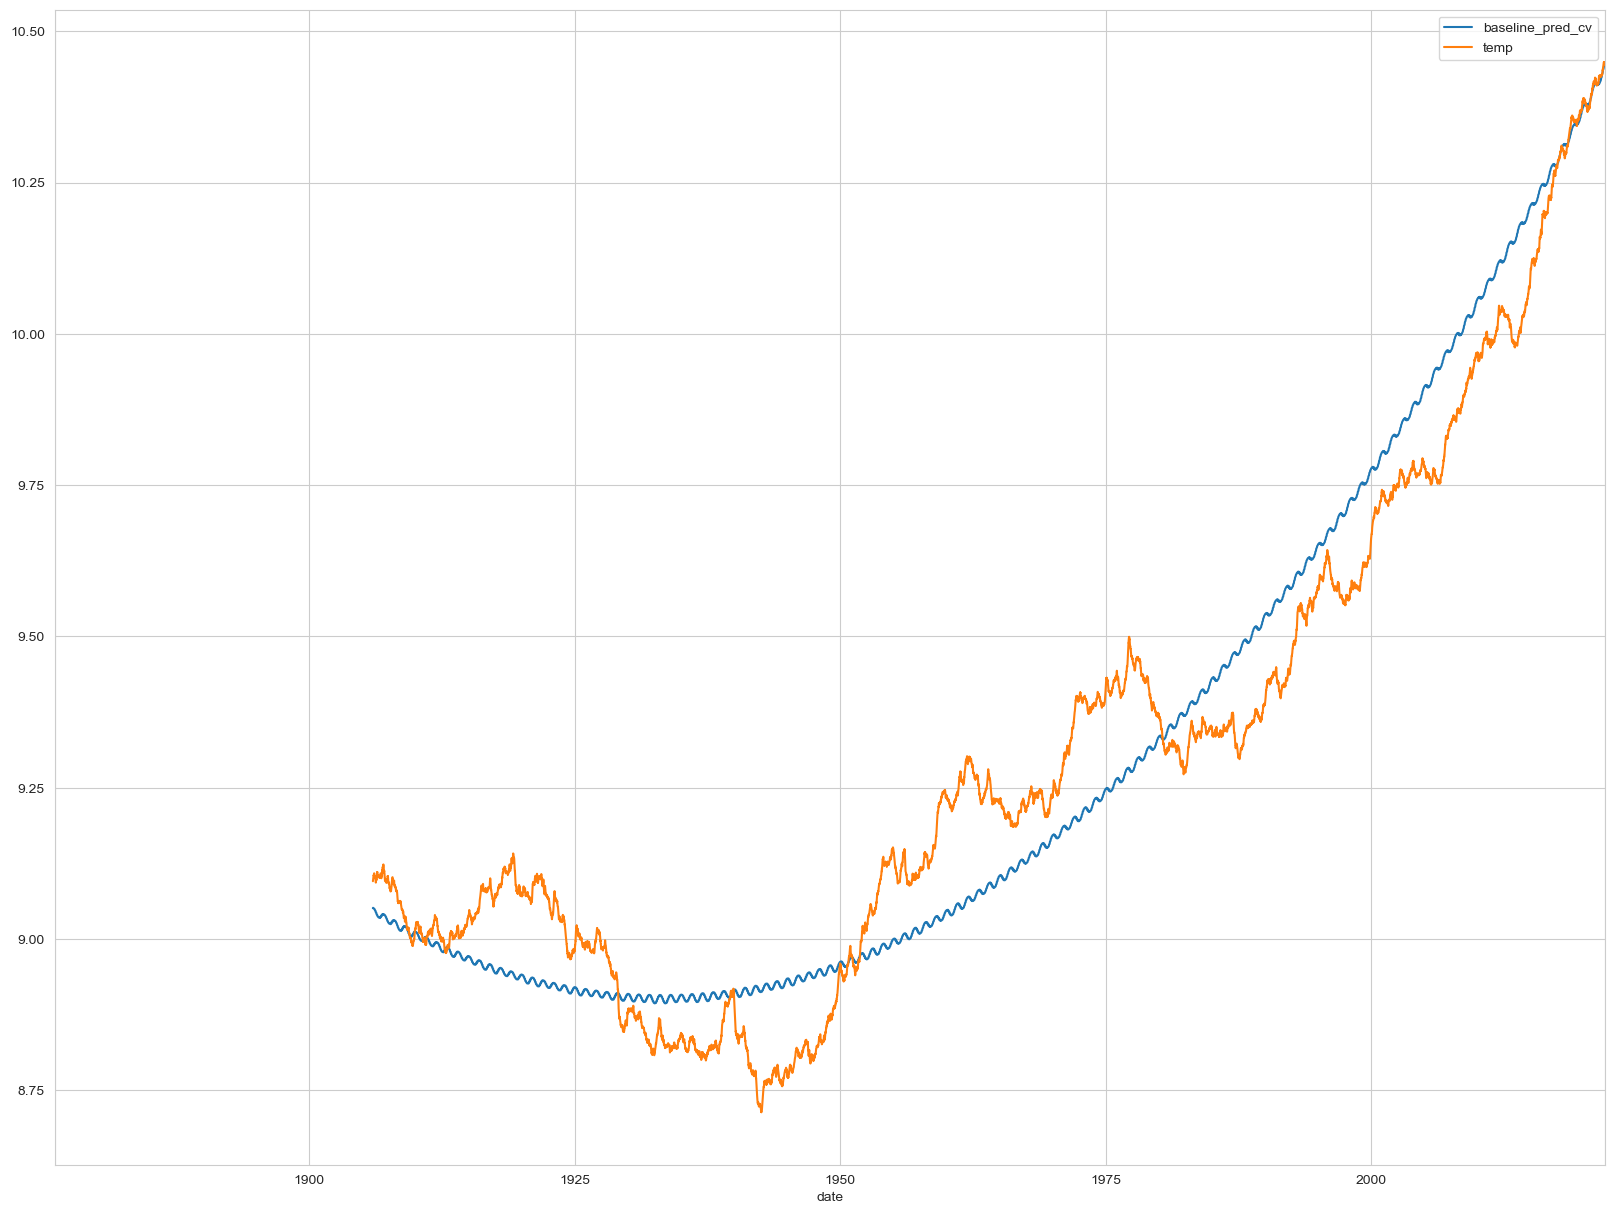

In [75]:
# to get an overview with rolling window of 30 years (365 days is maybe not the best)
years_30 = 30 *365
#train_30_years = train.baseline_pred_cv.rolling(window = years_30).mean()
train_30_years = train[['baseline_pred_cv', 'temp']].rolling(window = years_30).mean()
train_30_years.plot(figsize = (20,15))

In [23]:
remainder = train['remainder'].reset_index()
remainder.to_csv('data/remainder_baseline.csv',index=False)

## Check Residual

In [42]:
# residual noise

remainder['residuals'] = remainder['remainder'] - train['arima_pred']

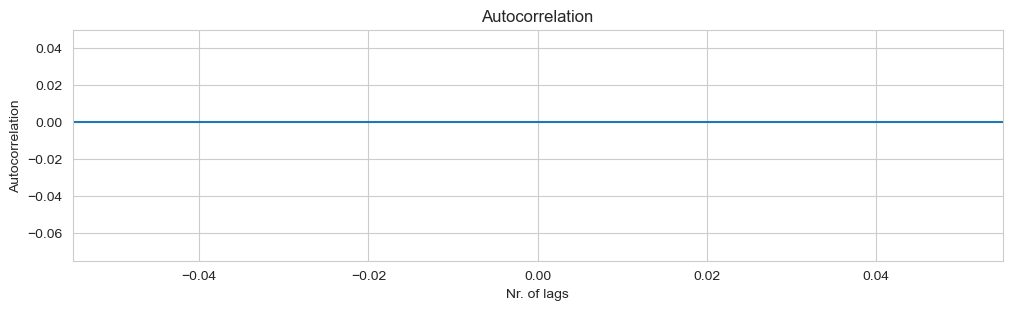

In [43]:
# plot autocorrelation function

plot_acf(remainder['residuals'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation')
plt.ylim(-0.075,0.05)
plt.show()


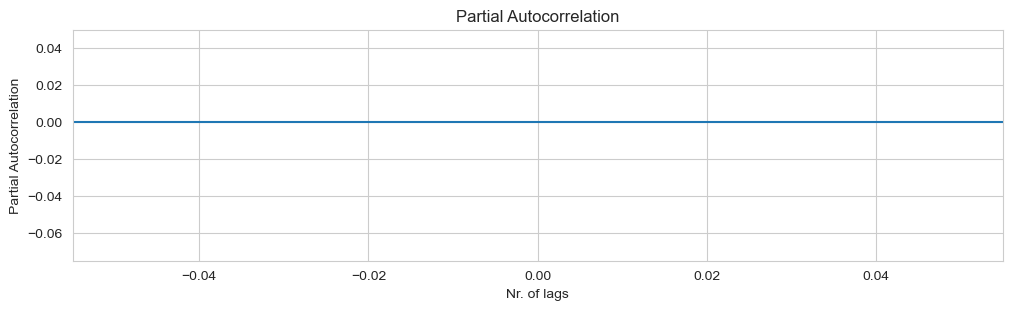

In [44]:
# plot partial autocorrelation function

plot_pacf(remainder['residuals'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
plt.ylim(-0.075,0.05)
plt.show()

# Model Remainder with (S)AR(I)MA

In [78]:
remainder_data = train['remainder']

In [79]:
arima_model = pm.auto_arima(
    remainder_data, 
    start_p=0,
    max_p=5,
    seasonality = False,
    stationarity = True,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=248674.626, Time=4.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=296780.147, Time=0.63 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=241677.277, Time=1.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=260430.200, Time=3.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=296778.147, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=240710.242, Time=1.81 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=240460.179, Time=2.77 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=240449.061, Time=2.84 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=240442.515, Time=4.21 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=240446.915, Time=7.94 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=240440.724, Time=30.59 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=240442.968, Time=16.60 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=240444.187, Time=6.63 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=240440.404, Time=4.29 sec
 AR

# FORECAST for test set

In [81]:
test = pd.read_csv('data/test.csv',index_col=0,parse_dates=True)
test.shape

(365, 1)

In [82]:
# timestep should continue after train 
test['timestep'] = list(range(train.shape[0],train.shape[0]+test.shape[0]))

In [83]:
# add month
test['month'] = test.index.month

In [84]:
# features and target for test set
X_test_baseline = test[['timestep','month']]
y_test = test['temp']

In [85]:
test['baseline_pred_cv'] = baseline_model_cv.predict(X_test_baseline)

In [86]:
test['arima_pred'] = arima_model.predict(test.shape[0], return_conf_int=True)[0]


In [87]:
# to combine it with baseline_pred
test['total_pred_new'] = test['baseline_pred_cv'] + test['arima_pred']

In [88]:
test[['temp','total_pred_new','arima_pred']].head()

,temp,total_pred_new,arima_pred
date,,,
2022-01-01,12.0,9.546436,7.978702
2022-01-02,9.9,7.220316,5.652472
2022-01-03,8.9,5.770240,4.202285
2022-01-04,6.4,4.849375,3.281309
2022-01-05,3.8,4.203428,2.635251


In [89]:
r2_ts = round(r2_score(y_test, test['total_pred_new']),6)
print(f"r2_score: {r2_ts}")

r2_score: 0.773891
